In [6]:
import numpy as np 
import math
#import peakutils
#import numpy.fft as fft
#import matplotlib as mpl 
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker 
#from matplotlib import cm  
import scipy.integrate 
#import scipy.signal as signal 
import pandas as pd
#from scipy.stats import sem

#import pickle 
#import random as rand  
from numpy import random

#from sklearn import decomposition 
from deap import creator, base, tools, algorithms 
#from sklearn.decomposition import PCA
#from mpl_toolkits.mplot3d import Axes3D
#from sklearn.cluster import KMeans  
#import os.path 

### <font color = 'brown'>Visualizing Raw Data</font>

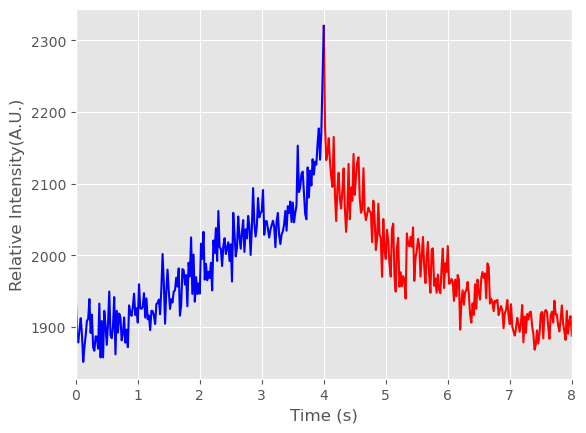

In [7]:
# DATA = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/expdataBB_from4.dat", header=None,sep=r"\s+",names=['time','expInt','expSEM'])
# #print(DATA[0:5])

# x = DATA['time']
# y = DATA['expInt']
# y_WHAT = DATA['expSEM']


# plt.plot(x, y, color = 'purple')

# plt.xlabel("Time (s)")
# plt.ylabel("Relative Intensity(A.U.)")
# plt.show()

# plt.plot(x, y_WHAT, color = 'pink')

# plt.xlabel("Time (s)")
# plt.ylabel("SEM")
# plt.show()

DATA_new = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/Dynamin1AB_kinetics_RawData.csv", header=None,sep=',',names=['time','expInt', 'expSEM'])
DATA_new_filtered = DATA_new[(DATA_new['time'] >= -4.00) & (DATA_new['time'] <= 0)]

#print(DATA_new_filtered[0:5])

DATA_4to4 = DATA_new[(DATA_new['time'] >= -4.00) & (DATA_new['time'] <= 4)]

x_new = DATA_4to4['time']+4
y_new = DATA_4to4['expInt']


#y_SEM= DATA_4to4['expSEM']

# plt.plot(x_new, y_SEM, color = 'orange')

# plt.xlabel("Time (s)")
# plt.ylabel("SEM")
# plt.show()

plt.style.use('ggplot') 
plt.plot(x_new[(x_new >= 4.0) & (x_new <= 8)], y_new[(x_new >= 4.0) & (x_new <= 8)], color='red')
plt.plot(x_new[(x_new >= 0) & (x_new < 4.02)], y_new[(x_new >= 0) & (x_new < 4.02)], color='blue')
plt.tick_params(right=False, top=False)

plt.xlabel("Time (s)")
plt.xlim(0,8)
plt.ylabel("Relative Intensity(A.U.)")
plt.savefig('dynamin_raw_fluorescence.png', dpi=900)
plt.show()



# <font color='red'>The class belows has the cost function and ODEs, as well as the plotting function</font>


In [20]:
'''
The deterministic model of biological oscillator
''' 
class Oscillator: 
	
	def __init__(self, parameter_ranges, params, Dsol0): #Dmem0): 
		#parameter_ranges and params will only include those PARAMETERS that will be UNDER OPTIMIZATION
		self.nParams = len(params)   
		self.paramsToOpt = params #model parameters to be optimized
		self.parameter_ranges = parameter_ranges #allowed parameter ranges  
		self.tMax = 8.5
		
		#3D to 2D lengthscale in um
		self.h = 0.01
		VAratio=1.91
		self.Atotal=4.34
		self.Acluster=0.023
		self.V=self.Atotal*VAratio
	#Dimensionality factor, should be the same in dense and dilute
		self.gamma = self.V/(self.Atotal*self.h)
	#define system geometry for the dense clusters.
		# self.AtotalDense=0.57
		# self.AclusterDense=0.026
		# self.VDense=self.AtotalDense*VAratio 

	# #Dimensionality factor, should be same in dense and dilute
	# 	self.gammaDense = self.VDense/(self.AtotalDense*self.h)
	# 	#print("VALUE OF slef.gammaDENSE IS: " + str(self.gamma))    
	# 	self.densIncrease = 7 #factor increase in density on the membrane
		targetIncrease=45 #how much should intensity increase 
		print("AB isoform is GOINGGGGGG!")              
		
		self.Dsol0 = Dsol0 #initial dynamin conc.
		#self.Dmem0 = Dmem0 #initial dynamin mem copies/um2

		expDt=0.02 
		nTimePoints=int(self.tMax/expDt)
		self.timePoints=[i*expDt for i in range(nTimePoints)] 
		self.expdata_unfiltered = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/Dynamin1AB_kinetics_RawData.csv", header=None,sep=',',names=['time','expInt', 'expSEM'])
		self.expdata_0 = self.expdata_unfiltered[(self.expdata_unfiltered['time'] >= -4.00) & (self.expdata_unfiltered['time'] <= 4)]
		new_index = range(len(self.expdata_0))
		self.expdata = self.expdata_0.set_index(pd.Index(new_index))
		startToZero = 4 
		self.expTime = self.expdata.time + startToZero 

        #make relative intensity higher!
		self.delIntensity=(np.max(self.expdata.expInt)-targetIncrease*self.expdata.expInt[0])/(1.0-targetIncrease)
		print('delIntensity HAS A VALUE OF: '+str(self.delIntensity))
        
		self.modes = [self.evaluate_parms]    
		self.threshold = -500000  

		
	def costChi(self, Y): 
		#Define relative intensity that is compared to the experimental data
		relInt=(self.expdata.expInt-self.delIntensity)/(self.expdata.expInt[0]-self.delIntensity)
		sem=self.expdata.expSEM/(self.expdata.expInt[0]-self.delIntensity)
		copies=Y*self.V*602
		# c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
		ae=copies[6]/self.Acluster #Dclus_hydro

        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac+ae), ac[0]) #relative intensity over time compared to initial amount of dynamin at the beginning (Dmem)
		nPt=len(relInt)
		nPsol=len(acd)
		if(nPsol<nPt):
			cost=self.threshold*2
			print(nPsol)
			print("too few points in solution") 
			print(nPsol)
			print("need: "+str(nPt)+ " points.")
		else:
			sum=0
			for i in range(nPt):
				df=relInt[i]-intensRatio[i]
				sum=sum+df*df/(sem[i]*sem[i]) 
			cost=-sum
		return [cost]
    
		
	def isViableFitness(self, fit):
        #the cost function is to be maximized, greater than some threshold
		return fit >= self.threshold
		
	def isViable(self, point): 
		fitness = self.evaluate_parms(point)  
		
		return self.isViableFitness(fitness[0]) #don't need zero index if 1D
		
	#evaluates a candidate  
	def evaluate_parms(self, candidate): 
		solutions = self.simulate(candidate) 
		# copies=solutions*self.V*602
		# acd=copies[4]/self.Acluster #Dclus2D
		# ad=copies[5]/self.Acluster #Dclus3D

		# twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point

		chiPre=self.costChi(solutions)
		return [chiPre] # twoDvs3D[0]]

        
#simulate a candidate pre-stimulation
	def simulate(self, candidate):
		
		# Values to convert to 3D units 
		#DmemDens=self.Dmem0 #units of /um2
		DmemDens = candidate[8]
		RdiluteDens = candidate[1]
		RclusDens=DmemDens/candidate[3]  #5 is targetDensRatio

		# Input species concentrations
        #convert all densities to uM units
		Dsol0=self.Dsol0 #units of uM: this is equilibrium pre-activation
		Dmem0=DmemDens*self.Atotal/self.V/602.0 
		Rclus0=RclusDens*self.Acluster/self.V/602.0
		Rdilute0=RdiluteDens*self.Atotal/self.V/602.0
		D2Dclus = 0
		Dclus = 0
		Dclus_hydro = 0
		#Ddis = 0
		initValues=np.array([Dsol0, Dmem0, Rclus0, Rdilute0, D2Dclus, Dclus, Dclus_hydro]) # Ddis])

        # rate constants for model (s^-1)
		kfDRC=candidate[0] #binding to cluster activator, irreversible
		kfDRD=candidate[4] #binding to dilute recruiter is reversible
		kfDydy=kfDRC*candidate[2] #4 is targetRateRatio
		kbDRD=Dsol0*Rdilute0/Dmem0*kfDRD
		kfhyd=candidate[5] #hydrolysis reaction of dynamin 
		kfhyd_propagation = candidate[6]
		GTPconc = candidate[7]
		kfdis = candidate[9]
		#kfdisProp = candidate[10]

		
		rateParams=np.array([kfDRC, kfDRD, kbDRD, self.gamma, kfDydy, kfhyd, kfhyd_propagation, GTPconc, kfdis]) #, kfdisProp])
		
        #Solve the ODE from 0 to tMax (8.5 seconds)
		solution = scipy.integrate.solve_ivp(fun=self.dynaminODE, method='Radau', t_span=(0, self.tMax), y0=initValues, t_eval=self.timePoints, args=(rateParams,), rtol=1e-7, atol=1e-9)
		return solution.y


	def dynaminODE(self, t, y, rateParams): 
		# Rate constants
		kfDRC=rateParams[0] #rate binding to activator in cluster, irreversible
		kfDRD=rateParams[1] #rate binding to dilute recruiter from solution
		kbDRD=rateParams[2] #rate of UNbinding from membrane - seems to be used to unbind from dynamin Dmem0
		gamma=rateParams[3] #a demensionality factor taking into account the volume and area of the system
		kfDydy=rateParams[4] #rate constant for dynamin-to-dynamin assembly
		# new parameters for disassembly
		kfhyd=rateParams[5] #rate of hydrolysis of final dynamin helix
		kfhyd_propagation = rateParams[7]
		GTPconc=rateParams[6]
		kfdis = rateParams[7]
		#kfdisProp = rateParams[8]

		# Species ("initValues" called in simulate)
		Dsol0 = y[0]
		Dmem0 = y[1]
		Rclus0 = y[2] #Aclus in paper
		Rdilute0 = y[3] #Rmem in paper
		D2Dclus = y[4]
		Dclus = y[5]
		Dclus_hydro = y[6]
		#Ddis = y[7]

		# 2nd order rate expressions 
		bind3DtoCluster = kfDRC*Dsol0*Rclus0 #rate of dynamin binding to the cluster from solution (3D)
		bind2DtoCluster = kfDRC*gamma*Dmem0*Rclus0 #rate of dynamin binding to the cluster from 2D
		bind3DtoDilute = kfDRD*Dsol0*Rdilute0 #rate of dynamin binding to recruiter (not in cluster) from solution (3D)
		bind2DtoDyn = kfDydy*gamma*Dmem0*D2Dclus #rate of dynamin on membrane binding to dynamin in cluster formed from 2D
		bind2Dto3DDyn = kfDydy*gamma*Dmem0*Dclus #rate of dynamin on membrane binding to dynamin cluster formed from 3D
		bind3DtoDyn = kfDydy*Dsol0*D2Dclus #rate of dynamin binding to 3D dynamin
		bind3Dto3DDyn = kfDydy*Dsol0*Dclus #rate of dynamin binding to 3D dynamin (cluster bound)

		# New, added expressions for rate of Dclus_hydro
		creation_Dclus_hydro = kfhyd*Dclus*GTPconc 
		creation_2Dclus_hydro = kfhyd*D2Dclus*GTPconc
		prop2Dclus = kfhyd_propagation * D2Dclus * Dclus_hydro
		propDclus = kfhyd_propagation * Dclus * Dclus_hydro
		
		disDhydro = kfdis*Dclus_hydro
		#disDhydroProp = kfdisProp*Ddis*Dclus_hydro


        #dynamin in solution - Dsol
		Dsol_ODE = -bind3DtoCluster - bind3DtoDilute + (kbDRD*Dmem0) - bind3DtoDyn - bind3Dto3DDyn + disDhydro
        #dynamin on membrane - Dmem
		Dmem_ODE = -bind2DtoCluster + bind3DtoDilute - (kbDRD*Dmem0) - bind2DtoDyn - bind2Dto3DDyn 
        #available (unbound) recruiter on the cluster membrane - Aclus
		Aclus_ODE = -bind3DtoCluster - bind2DtoCluster
        #available (unbound) recruiter on the membrane dilute - Rmem
		Rmem_ODE = -bind3DtoDilute + (kbDRD*Dmem0)
        #Dynamin in cluster from 2D  - D2dclus
		D2dclus_ODE = bind2DtoCluster + bind2DtoDyn + bind2Dto3DDyn - creation_2Dclus_hydro - prop2Dclus
    	#Dynamin in cluster from 3D - Dclus
		Dclus_ODE = bind3DtoCluster + bind3DtoDyn + bind3Dto3DDyn - creation_Dclus_hydro - propDclus
		#Dynamin hdyrolyzed species after Dclus + D2Dclus GTP hydrolysis
		Dclus_hydro_ODE = creation_2Dclus_hydro + creation_Dclus_hydro + prop2Dclus + propDclus - disDhydro #- disDhydroProp

		#Ddis_ODE = disDhydro #+ disDhydroProp  

		dydt=np.array([Dsol_ODE, Dmem_ODE, Aclus_ODE, Rmem_ODE, D2dclus_ODE, Dclus_ODE, Dclus_hydro_ODE])# Ddis_ODE])
		return(dydt)
    
	def plotModel(self, candidate, file = None, showConc = False, mode = None, save = None):     		
		t = self.timePoints

		expInt = np.copy(self.expdata.expInt)
		delIntensity = np.copy(self.delIntensity)
		time_model = np.copy(self.timePoints)
		time_exp = np.copy(self.expTime)

		relInt = (expInt-delIntensity)/(expInt[0]-delIntensity)

		concentrations = self.simulate(candidate)
		copies = concentrations*self.V*602
		
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
		ae=copies[6]/self.Acluster #DclusHydro

        #2D vs 3D recruitment growth
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
       
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac+ae), ac[0])
		#plt.style.use('ggplot') 
		plt.plot(time_exp, relInt, color="green",label="Experiment", alpha = 0.7)
		plt.plot(time_model, intensRatio, color="black", label='Model', linewidth = 3.5)

		plt.tick_params(right=False, top=False)
		plt.xlabel('Time (s)')
		plt.xlim(0,8)
		plt.ylabel('Relative Intensity (A.U.)')
		legend = plt.legend(loc = 'upper right', prop={'size': 12})
		legend.get_frame().set_facecolor('white')
		legend.get_frame().set_edgecolor('black')
		plt.show()

		# Concentrations for time series plot
		Dsol = concentrations[0]
		Dmem = concentrations[1]
		D2dclus = concentrations[4]
		Dclus = concentrations[5]
		Dclus_hydro = concentrations[6]
		#Ddis = concentrations[7]

		TOTAL = Dsol + Dmem + D2dclus + Dclus_hydro + Dclus 


		D2dclus_CN = concentrations[4] *self.V*602
		Dclus_CN = concentrations[5]*self.V*602
		Dclus_hydro_CN = concentrations[6]*self.V*602
		#Ddis_CN = concentrations[7]*self.V*602
		
		if save == True:
			plt.style.use('ggplot') 
			#plt.gca().set_facecolor('white')
			plt.plot(time_exp, relInt, color="green",label="Experiment", alpha = 0.7)
			plt.plot(time_model, intensRatio, color="black", label='Model', linewidth = 3)

			plt.tick_params(right=False, top=False)
			# plt.gca().spines['top'].set_color('black')
			# plt.gca().spines['right'].set_color('black')
			# plt.gca().spines['bottom'].set_color('black')
			# plt.gca().spines['left'].set_color('black')
			plt.xlabel('Time (s)')
			plt.xlim(0,8)
			plt.ylabel('Relative Intensity (A.U.)')
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')
			plt.savefig('dynaminOpt_bestSolution.png', dpi=900)
			plt.close()

			plt.style.use('ggplot') 
			plt.plot(t, Dclus_hydro, color = 'purple', label = 'Dclus (hydro)', linewidth = 3.5)
			plt.plot(t, Dclus, color = 'blue', label = "Dclus", linewidth = 3.5)
			plt.plot(t, D2dclus, color = 'orange', label = 'D2dclus', linewidth = 3.5)
			#plt.plot(t, Ddis, color = "red", label = 'Ddis', linewidth = 3.5)
			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			plt.xlim(0,8)
			plt.ylabel('Concentration (uM)')
			
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')
			plt.savefig('dynamin_Opt_speciesTrajectory.png', dpi=900)
			plt.close()
			
			plt.style.use('ggplot') 
			plt.plot(t, TOTAL, color = 'red', label = "Dclus + D2Dclus + Dsol + Dmem + Dclus_Hydro")
			#plt.title("Conservation of Mass?")
			plt.ylabel("Total Concentration (uM)")
			plt.xlabel("Time(s)")
			plt.xlim(0,8)

			plt.tick_params(right=False, top=False)
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')
			plt.savefig('dynaminOpt_consvOfMass.png', dpi=900)
			plt.close()	

			
			plt.style.use('ggplot') 
			
			plt.plot(t, Dclus_hydro_CN, color = 'purple', label = 'Dclus (hydro)', linewidth = 3.5)
			plt.plot(t, Dclus_CN, color = 'blue', label = "Dclus", linewidth = 3.5)
			plt.plot(t, D2dclus_CN, color = 'orange', label = 'D2dclus', linewidth = 3.5)

			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			plt.xlim(0,8)
			plt.ylabel('Copy Number')
			
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')
			plt.savefig('speciesCNtrajectory.png', dpi=900)
			plt.close()
		
		if showConc == True:
			plt.style.use('ggplot') 
			plt.plot(t, Dclus_hydro, color = 'purple', label = 'Dclus (hydro)', linewidth = 3.5)
			#plt.plot(t,Dclus_total, color = 'purple', label = "Dclus (total)", ls = '--', alpha = 0.3)
			plt.plot(t, Dclus, color = 'blue', label = "Dclus", linewidth = 3.5)
			plt.plot(t, D2dclus, color = 'orange', label = 'D2dclus', linewidth = 3.5)
			#plt.plot(t, Ddis, color = "red", label = 'Ddis', linewidth = 3.5)

			# plt.plot(t, Dsol, color = 'red', label = 'Dsol')
			# plt.plot(t, Dmem, color = 'pink', label = 'Dmem')
			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			# plt.xlim(0,4)
			plt.ylabel('Concentration (uM)')
			
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')			
			plt.show()


			plt.plot(t, Dclus_hydro, color = 'purple', label = 'Dclus (hydro)')
			plt.xlabel('Time (s)')
			plt.ylabel('Concentration (uM)')
			
			plt.legend(loc = 'upper right', prop={'size': 12})
			plt.show()

			plt.style.use('ggplot') 
			plt.plot(t, Dsol, color = 'green', label = 'Dsol', linewidth = 2)
			#plt.plot(t, Dmem, color = 'pink', label = 'Dmem', linewidth = 3)
			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			# plt.xlim(0,4)
			plt.ylabel('Concentration (uM)')
			
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')			
			plt.show()


			plt.style.use('ggplot') 
			plt.plot(t, TOTAL, color = 'red', label = "Dclus + D2Dclus + Dsol + Dmem + Dclus_Hydro")
			#plt.title("Conservation of Mass?")
			plt.ylabel("Total Concentration (uM)")
			plt.xlabel("Time(s)")
			plt.tick_params(right=False, top=False)
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')			
			plt.show()	

			
			plt.style.use('ggplot') 
			
			plt.plot(t, Dclus_hydro_CN, color = 'cyan', label = 'Dclus (hydro)')
			plt.plot(t, Dclus_CN, color = 'pink', label = "Dclus")
			plt.plot(t, D2dclus_CN, color = 'orange', label = 'D2dclus')
			#plt.plot(t, Ddis_CN, color = "red", label = 'Ddis')

			
			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			plt.ylabel('Copy Number')
			
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')
			plt.show()
			

			# Dmem_uM = Dmem/self.Atotal*self.V*602 
			# plt.style.use('ggplot') 
			# plt.plot(t, Dmem_uM, color = 'green', label = 'Dmem')

			# plt.xlabel('Time (s)')
			# plt.ylabel('Concentration (/uM^2)')
			
			# plt.legend(loc = 'upper right', prop={'size': 12})
			# plt.show()

		if file is not None:
			f1 = open(str(file), "w")
			dfs = pd.DataFrame([self.timePoints, intensRatio, twoDvs3D]).T
			dfs.to_csv(f1, sep='\t', header=["time", "intensRatio", "twoDvs3d"])

![Alt text](image-5.png)

![Alt text](image-12.png)

# <font color='red'>Solver runs the genetic algorithm (you'll see in __init__, uses package called DEAP for genetic operations)</font>

# <font color='grey'>
A parameter is a single rate constant or concentration of macromolecule (dynamin)
 - which is a gene!
A genotype is a combination of parameters 
 - a combination of genes - like a chromosome
A phenotype is a single number/solution
 - the chi-squared COST, fitness of the genotype (how well it matches the experimental data)
The population is the collections of all of the indivudals (genotypes -> phenotype) in a geneeration
 - reminder: evolution CANNOT occur on the individual level

How do the operators actually work
 - mutation
 - crossover (mate)
 - selection 

 Operators work on the population level
 
 The GA is most sensitive to population size
 </font>

In [9]:
'''
The main class
'''
class Solver:
	def __init__(self, model, populationSize=3000, NGEN = 3, nsamples = 1e3):                                                      
		self.model = model            
		self.populationSize = populationSize         
		self.NGEN = NGEN  
		self.nsamples = int(nsamples) 	
		self.indpb = 0.75     	
		
		#GA operators
		creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
		creator.create("Candidate", list, fitness=creator.FitnessMax)  		
		self.toolbox = base.Toolbox()	 
		self.toolbox.register("candidate", self.generateCandidate)  #function to create individuals
		self.toolbox.register("population", tools.initRepeat, list, self.toolbox.candidate)   #function to create a population
		self.toolbox.register("mate", tools.cxTwoPoint) #crossover
		self.toolbox.register("mutate", self.mutateCandidate, indpb=self.indpb, mult=0.5) #mutation
		self.toolbox.register("select", tools.selTournament, tournsize=int(self.populationSize/10)) #selection	
	
	#estimate initial values with GA
	def findNominalValues(self):    	 	
		nominalVals = []
		fitnessVals = []
		for evalMode in self.model.modes: 
			nominalValsMode = []
			fitnessValsMode = []
			self.toolbox.register("evaluate", evalMode)  #creates a function used to evaluate the fitness of individuals in the population
			#initialize new random population
			self.popu = self.toolbox.population(self.populationSize)  	 
			
			for gen in range(self.NGEN):  
				print("Current generation")
				print(gen)
				#generate offsprings with crossover and mutations
				offspring = algorithms.varAnd(self.popu, self.toolbox, cxpb=0.5, mutpb=0.75)  
				#evaluate individuals
				fits = self.toolbox.map(self.toolbox.evaluate, offspring) 
				for fit, ind in zip(fits, offspring):
					[cost]=self.model.evaluate_parms(ind)  #evalutates the cost (chisquared) of each individual      
					
					if cost[0]>=self.model.threshold and ind not in nominalValsMode:  #appends the individual to the list of "good"
						nominalValsMode.append(ind)
						fitnessValsMode.append(fit[0]) 
						#twoDValsMode.append(twoD)  
					ind.fitness.values = fit[0]     
				#tournament selection
				self.popu = self.toolbox.select(offspring, k=len(self.popu))  #selects individuals for the next generation

			print("Number of viable points: " + str(len(nominalValsMode))) #number of individuals meeting threshold criterion
			nominalVals.extend(nominalValsMode)  
			fitnessVals.extend(fitnessValsMode)

		return [nominalVals, fitnessVals]        
		
	#creates an array of random candidates  
	def generateCandidate(self): 
		candidate = []
		for ind in range(self.model.nParams):
			low=self.model.parameter_ranges[self.model.paramsToOpt[ind]]["min"]
			hi=self.model.parameter_ranges[self.model.paramsToOpt[ind]]["max"]
			value=random.uniform(math.log10(low),math.log10(hi))
			candidate.append(pow(10, value))
		return creator.Candidate(candidate) 	
		
	def checkOutAllBounds(self, candidate):
		for idx, val in enumerate(candidate):
			if self.checkOutOfBounds(candidate, idx): 
				return True  
		return False      
				
	def checkOutOfBounds(self, candidate, idx): 
		#if out of bounds return True 
		if candidate[idx] < self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"] or candidate[idx] > self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]: 
			return True
		return False    		
	
	#returns a tuple of mutated candidate	
	def mutateCandidate(self, candidate, indpb, mult): 	
		for idx, val in enumerate(candidate):	
			rnd = random.uniform(0, 1)
			if rnd >= indpb:
				rnd2 = random.uniform(1 - mult, 1 + mult)   
				candidate[idx] = val*rnd2	
				if candidate[idx] < self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"]: 
					candidate[idx] = self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"]  
				if candidate[idx] > self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]:  
					candidate[idx] = self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]    					
		return candidate,     
	
	def getViablePoints(self, points):
		viable = list() 
		#fitVals = []        
		i = 0
		print(" getting Viable points")        
		for point in points:  
			i += 1
			if i % 1000 == 0:
				print(i)     
			
			#check if point is viable
			fitness = self.model.evaluate_parms(point) 
			if(fitness[0] >= self.model.threshold):
			#if self.model.isViable(point):
				augPoint=[]
				augPoint.append(fitness)
				for j in range(self.model.nParams):
					augPoint.append(point[j])
				viable.append(augPoint)   		
				#fitVals.append(fitness[0])
		print("shape of viable")
		print(np.shape(viable))
		return viable          
	
	def run(self, save = None):    
		#estimate the initial viable set 
		[viablePoints, viableFitness] = self.findNominalValues()

		fitValues=[]
		negFitValues=[]   

		for i in range(len(viableFitness)):
			fitValues.append(viableFitness[i][0])
			negFitValues.append(-viableFitness[i][0])
            
		idSort=np.argsort(negFitValues) 
		
		print("Best solution from initial sampling")
		print("Fitness: ", fitValues[idSort[0]])
		print("Best parameters: ", (viablePoints[idSort[0]]))
		self.model.plotModel(viablePoints[idSort[0]], save = True)
		print("WORST solution from initial sampling")
		self.model.plotModel(viablePoints[idSort[len(idSort)-1]])

		if save == True:
				fname="optimizedParms_dynamin1AB.txt"
				sortFit=sorted(fitValues, reverse=True) #descending order
				#print(sortFit[len(viableFitness)-1])
				sortPoint1=[]
				sortPoint2=[]
				sortPoint3=[]
				sortPoint4=[]
				sortPoint5 = [] #for new
				
				idSort=np.argsort(negFitValues) 
				#print(idSort)
				for i in range(len(idSort)):
					index=idSort[i]
					optParms=viablePoints[int(index)]
					#curr2D=twoDVals[int(index)]
		
					kfDRC=optParms[0]
					kfDRD=optParms[4] #binding to dilute and cluster recruiter are coupled
					kfDydy=kfDRC*optParms[2] #candidate[1]
					Dsol0=self.model.Dsol0 #units of uM
					
					#new 
					kfhyd = optParms[5]
					kfhyd_propagation = optParms[6]
					GTPconc = optParms[7]

					DmemDens=self.model.Dmem0
					RclusDens=DmemDens/optParms[3]  
					RdiluteDens = optParms[1]
					kfDense = optParms[5]
					#convert all densities to uM units
					Dmem0=DmemDens*self.model.Atotal/self.model.V/602.0 
					# Rclus0=RclusDens*self.model.Acluster/self.model.V/602.0 #Rclus0 is never called....
					Rdilute0=RdiluteDens*self.model.Atotal/self.model.V/602.0
					#rates for model
					#off rates, s-1
					kbDRD=Dsol0*Rdilute0/Dmem0*kfDRD
					kbDRC=kbDRD
					
					allParms1=np.array([kfDRC, RdiluteDens, Dsol0, DmemDens]) 
					allParms2=np.array([kfDRD, kfDydy, RclusDens, kfDense])  
					allParms3=np.array([kbDRC, kbDRD, self.model.gamma])
					allParms4=np.array([optParms[2], optParms[3]]) # curr2D])
					allParms5=np.array([kfhyd, kfhyd_propagation, GTPconc])

					sortPoint1.append(allParms1)
					sortPoint2.append(allParms2)
					sortPoint3.append(allParms3)
					sortPoint4.append(allParms4)
					sortPoint5.append(allParms5)
					
					
				df=pd.DataFrame([sortFit, sortPoint1, sortPoint2, sortPoint3, sortPoint4, sortPoint5]).T
				df.to_csv(fname, sep='\t',header=["Chi2","kfDRC, RdiluteDens, Dsol0, DmemDens","kfDRD, kfDydy, RclusDens, kfDense", "kbDRC, kbDRD, gamma","rateRatio, densRatio", "kfhyd, kfhyd_propagation, GTPconc"])
				print("wrote to file")
				

# <font color='red'>Define parameter ranges and initial conditions</font>

In [10]:
## DEFINE YOUR RANGES FOR THE GA 

parameter_ranges = { 
            #units of uM-1s-1
            "kfDRC": {"min": 0.1, "max": 3}, # 0.0001 to 1
            "RdiluteDens": {"min": 1, "max": 500},           				        
            "targetRateR": {"min": 0.01, "max": 100},
            "targetDensR": {"min": 0.01, "max": 100},
            "kfDRD": {"min": 0.01, "max": 1}, # 0.0001 to 1
            #rate to bind activator in the dense phase
            #"kfDense": {"min": 0.0001, "max": 1},
            "kfhyd": {"min": 0.1, "max": 5}, # 0.0001 to 0.01
            "kfhyd_propagation": {"min": 0.1, "max": 100}, # 0.01 to 100
            "GTPconc": {"min":300, "max": 1000},
            "Dmem0": {"min": 10, "max": 80},
            "kfdis": {"min": 0.00001, "max": 0.0001}, #must be smaller than kfhyd....?
            #"kfdisProp": {"min": 0.001, "max": 1} 
            }   	
 
paramsToOpt=np.array(["kfDRC","RdiluteDens","targetRateR","targetDensR","kfDRD", "kfhyd", "kfhyd_propagation", "GTPconc", "Dmem0", "kfdis"]) # "kfdisProp"])


# <font color='red'>Simulate a model given input parameters</font>

AB isoform is GOINGGGGGG!
delIntensity HAS A VALUE OF: 1933.0938181818185


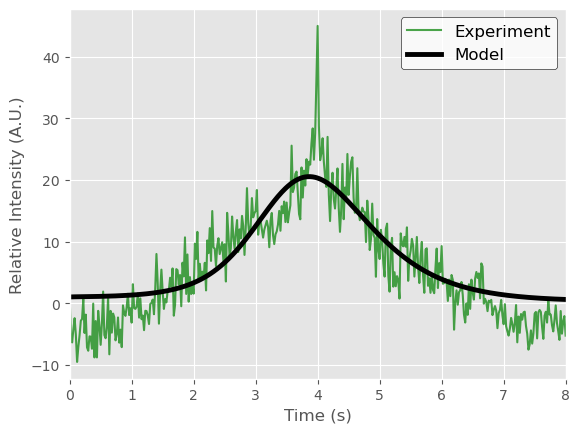

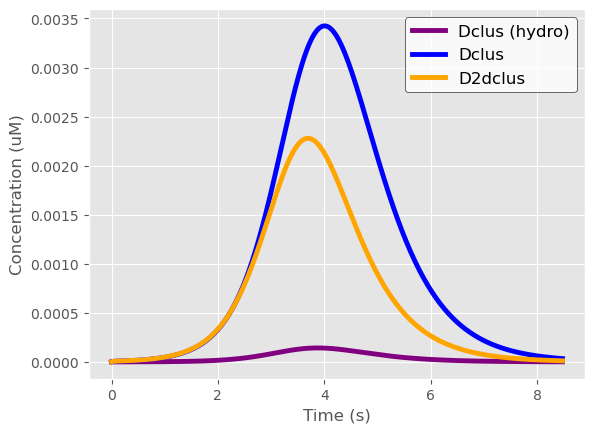

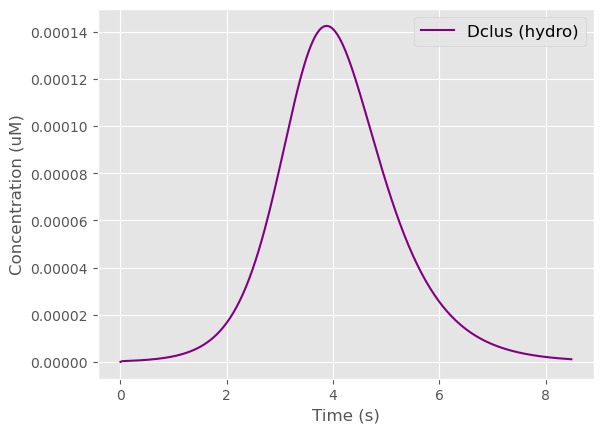

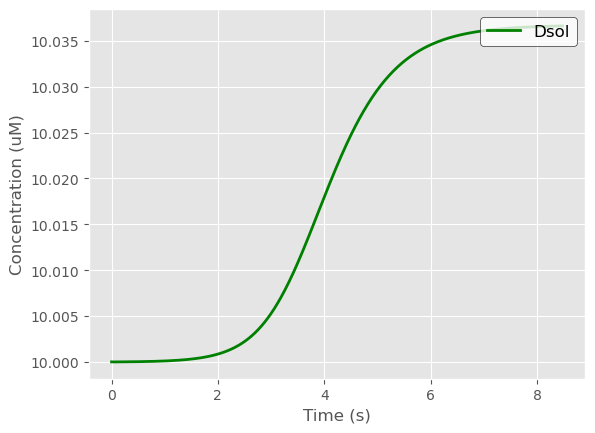

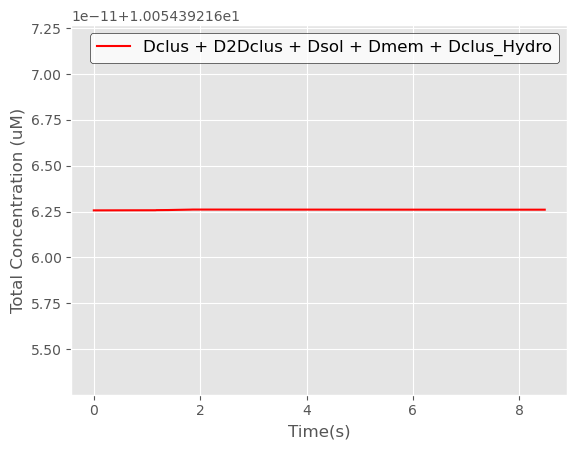

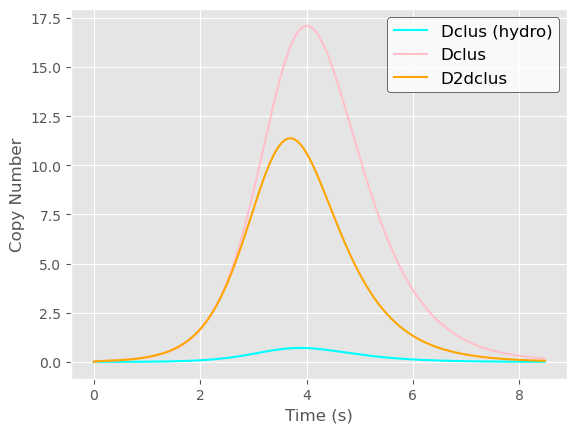

fitness: [-1049.1788243588842]


In [21]:
#initialize the model
model = Oscillator(parameter_ranges, paramsToOpt, 10) 
#Dsol0 = 10

#define a candidate set of rates 
#candidate_BAD = np.array([0.0024, 86.7117014087749, 53.76109799387347, 0.03613479551399369, 0.34973486053145464, 0.007797734909058662, 20, 644, 20.50569128216774])
#candidate_final = np.array([0.0017326069496228003, 86.7117014087749, 53.76109799387347, 0.03613479551399369, 0.34973486053145464, 0.007797734909058662, 30.207785720048385, 644.2414676371535, 20.50569128216774])

#candidate_dis = np.array([0.0030639813650906265, 3.627460059166232, 79.91905273505745, 0.03653069490007928, 0.13564567313177872, 0.2865652215494993, 15.342674377434056, 1000, 72.12628419943113, 0.00017209038776845462, 2.8475258930576324])
#candidate_dis2 = np.array([0.007129672230969613, 5.383061019185032, 17.664244394693167, 0.03728641399718233, 0.4382068823435466, 0.8176240538145778, 3.3876270352419993, 438.56332645277956, 80, 0.06289824249948874, 0.12218398389393])
candidate_dis3 = np.array([0.006991227931624193, 13.42399568650089, 49.88732535842113, 0.2265658483536875, 0.003240080503322995, 0.43728076291792595, 13.05857273512493, 915.7439377005649, 61.51769876723075, 0.07788040700889426, 0.0014588018360689988])
candidate_dis4 = np.array([0.03747553556174139, 2.5501009739017593, 16.39619104540131, 0.11859936691783803, 0.006987539068249752, 0.9209487692460746, 8.439624656567736, 1000, 23.086190713362623, 0.002707963808717346, 0.00227917841726791])
candidate_dis5 = np.array([0.015268039748554571, 18.929914002150742, 1.536418515305018, 0.049686738699049576, 0.4220449170869857, 0.2943462337274766, 2.6755418006052007, 475.5922143108078, 68.9547924241103, 0.0071658421916301444, 0.009240439826090862]) #most accurate species trajectory
candidate_dis6 = np.array([0.014704059429945286, 1.9297353013064373, 28.60430749995155, 0.28889046512331124, 0.001024953853849449, 0.35549251931630843, 17.73994680974939, 308.1588226732592, 48.13012745823866, 0.0029914546595573707, 0.054896837422113584])
candidate_dis7 = np.array([0.19920998711116378, 2.172458861775014, 2.9066274491153634, 17.318879523082558, 0.0006238793591488535, 0.21955681915326522, 38.73909049381994, 987.2376930123029, 49.70569634607179, 0.00024031976565007057])
candidate_dis8 = np.array([0.5411956490724477, 3.5542155931434856, 1.1473397389794797, 3.8748067871701473, 0.014675586617559183, 0.7626805858926015, 11.37207362768435, 779.2181385564895, 38.674519473645454, 3.2642401910064085e-05])
candidate_dis9 = np.array([3, 6.612070855426677, 0.15649895570616687, 21.30740843580352, 0.31627377480721036, 0.692025451445385, 10.94815403529973, 300, 62.541188998838656, 1.4465371168314694e-05])

# kfDRC = candidate[0] 
# RdiluteDens = candidate[1] 
# kfDydy = kfDRC*candidate[2] 
# RclusDens = DmemDens/candidate[3]  
# kfDRD = candidate[4] 
# kfhyd = candidate[5] 
# kfhyd_propagate = candidate[6]
# GTPconc = candidate[7]
# Dmemo = candidate[8]
# kfdis = candidate[9]
# kfdisProp = candidate[10]

solutions = model.simulate(candidate_dis9) 
model.plotModel(candidate_dis9, showConc = True, mode = "test", save = True)
timePts=model.timePoints
[fitness] = model.evaluate_parms(candidate_dis9) 
print("fitness: "+ str(fitness))


# <font color='red'>Use the GA to find a population of solutions over multiple generations</font>

AB isoform is GOINGGGGGG!
delIntensity HAS A VALUE OF: 1933.0938181818185
Current generation
0


/Users/cmdb/mambaforge/envs/ODE_solver_JOHNSON/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/cmdb/mambaforge/envs/ODE_solver_JOHNSON/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


296
too few points in solution
296
need: 400 points.
296
too few points in solution
296
need: 400 points.
379
too few points in solution
379
need: 400 points.
379
too few points in solution
379
need: 400 points.
Current generation
1
Current generation
2
Current generation
3
Number of viable points: 20828
Best solution from initial sampling
Fitness:  -1047.0381889023733
Best parameters:  [3, 6.612070855426677, 0.15649895570616687, 21.30740843580352, 0.31627377480721036, 0.692025451445385, 10.94815403529973, 300, 62.541188998838656, 1.4465371168314694e-05]


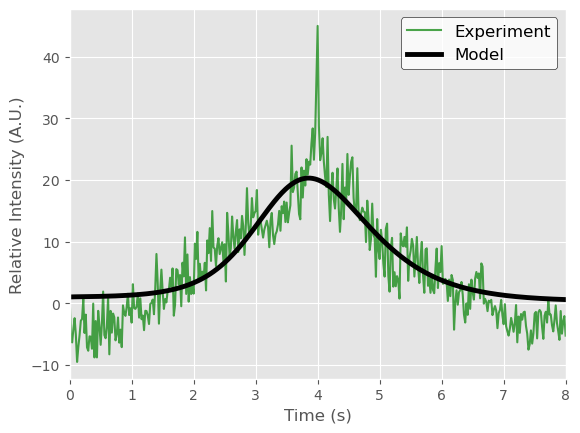

IndexError: index 7 is out of bounds for axis 0 with size 7

In [69]:
popSize = 8000
nGen = 4
nSamples = 2000
Dsol0=10

model = Oscillator(parameter_ranges, paramsToOpt, Dsol0)
solver = Solver(model, popSize, nGen, nSamples)
solver.run()


In [ ]:
parameterRanges = {
    "Dmem": {"min": 10, "max": 80},
    "3D Binding Rate": {"min": 0.0001, "max": 1},
    #"kfDRD": {"min": 0.0001, "max": 1},
    "Hydrolysis Rate": {"min": 0.0001, "max": 0.01},
    "Hyd Prop Rate": {"min": 5, "max": 100},
    "[GTP]": {"min": 300, "max": 1000},
}

opt_param_values = {
    "Dmem": [47.27422153983175, 47.27422153983175, 23.396303442147673, 26.147611676561397, 19.571610091595808, 39.86199545659888, 24.229809738694314, 28.681168675768145, 22.545122258687428, 19.33026295544393],  
    "3D Binding Rate": [0.0017326069496228003, 0.0035598134984075104, 0.6955603356871467, 0.025066089196652545, 0.0050380740953135765, 0.019229901315048453, 0.014581467633629054, 0.001990616898927127, 0.0019150426498299273, 0.36281737783658236],
    #"kfDRD": [0.06959129916521686, 0.06959129916521686, 0.0022220202892492434, 0.045176210431552996, 0.0001, 0.7642776752104142, 0.0006905018785006779, 0.00037442618249269204, 0.0007874991183660913, 0.0035181338012190266],
    "Hydrolysis Rate": [0.008734512642797999, 0.008734512642797999, 0.005514224188230993,  0.0029046264552392335, 0.005264915270501996, 0.002900058064453754, 0.0029643843882104816, 0.01, 0.007836816452413804, 0.004081981029081364],
    "Hyd Prop Rate": [24.000097397408663, 24.000097397408663, 65.22313344482802, 73.87393680044634, 39.53379457290873, 47.298531756991956, 59.06590293280448, 21.920936675842004, 37.63782555671546, 100],
    "[GTP]": [644.2414676371535, 300, 486.81214029671776, 539.1658227740767, 716.6564653245143, 400.63113080898705, 589.0149212052922, 471.9463249166528, 556.3575740478342, 560.8109473513181],
}

parameters = list(parameterRanges.keys())
ranges_min = [parameterRanges[param]["min"] for param in parameters]
ranges_max = [parameterRanges[param]["max"] for param in parameters]

fig, ax = plt.subplots(figsize=(10, 6))

handles = []  
labels = []   

for i, param in enumerate(parameters):
    min_val = parameterRanges[param]["min"]
    max_val = parameterRanges[param]["max"]
    ax.fill_between([i - 0.15, i + 0.15], min_val, max_val, color='lightblue', alpha=0.5, zorder=1)

# Add handle and label for blue boxes only once
handles.append(plt.Rectangle((0,0),1,1,fc="lightblue", alpha=0.5))
labels.append("Parameter Selection Ranges")

for i, param in enumerate(parameters):
    for val in opt_param_values[param]:
        ax.scatter(i, val, color='red', s=8, zorder=2)

# Add handle and label for red dots
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8))
labels.append("Optimized Parameter value")

ax.set_xticks(range(len(parameters)))
ax.set_xticklabels(parameters)
ax.set_ylabel('Parameter Values (log)')
ax.set_yscale('log')

ax.tick_params(axis='y', which='both', left=False, right=False)
ax.legend(handles, labels, loc='lower right', prop={'size': 12})  # Use custom handles and labels for legend
plt.title("n = 10 Simulations")
plt.savefig('parameterRangesAndOpt.png', dpi=900)

# Show plot
plt.show()








parameterRanges = {
    "Dmem": {"min": 10, "max": 80},
    "3D Binding Rate": {"min": 0.0001, "max": 1},
    #"kfDRD": {"min": 0.0001, "max": 1},
    "Hydrolysis Rate": {"min": 0.0001, "max": 0.01},
    "Hyd Prop Rate": {"min": 5, "max": 100},
    "[GTP]": {"min": 300, "max": 1000},
}

opt_param_values = {
    "Dmem": [47.27422153983175, 47.27422153983175, 23.396303442147673, 26.147611676561397, 19.571610091595808, 39.86199545659888, 24.229809738694314, 28.681168675768145, 22.545122258687428, 19.33026295544393],  
    "3D Binding Rate": [0.0017326069496228003, 0.0035598134984075104, 0.6955603356871467, 0.025066089196652545, 0.0050380740953135765, 0.019229901315048453, 0.014581467633629054, 0.001990616898927127, 0.0019150426498299273, 0.36281737783658236],
    #"kfDRD": [0.06959129916521686, 0.06959129916521686, 0.0022220202892492434, 0.045176210431552996, 0.0001, 0.7642776752104142, 0.0006905018785006779, 0.00037442618249269204, 0.0007874991183660913, 0.0035181338012190266],
    "Hydrolysis Rate": [0.008734512642797999, 0.008734512642797999, 0.005514224188230993,  0.0029046264552392335, 0.005264915270501996, 0.002900058064453754, 0.0029643843882104816, 0.01, 0.007836816452413804, 0.004081981029081364],
    "Hyd Prop Rate": [24.000097397408663, 24.000097397408663, 65.22313344482802, 73.87393680044634, 39.53379457290873, 47.298531756991956, 59.06590293280448, 21.920936675842004, 37.63782555671546, 100],
    "[GTP]": [644.2414676371535, 300, 486.81214029671776, 539.1658227740767, 716.6564653245143, 400.63113080898705, 589.0149212052922, 471.9463249166528, 556.3575740478342, 560.8109473513181],
}

parameters = list(parameterRanges.keys())
ranges_min = [parameterRanges[param]["min"] for param in parameters]
ranges_max = [parameterRanges[param]["max"] for param in parameters]

fig, ax = plt.subplots(figsize=(10, 6))

handles = []  
labels = []   

for i, param in enumerate(parameters):
    min_val = parameterRanges[param]["min"]
    max_val = parameterRanges[param]["max"]
    ax.fill_between([i - 0.15, i + 0.15], min_val, max_val, color='lightblue', alpha=0.5, zorder=1)

# Add handle and label for blue boxes only once
handles.append(plt.Rectangle((0,0),1,1,fc="lightblue", alpha=0.5))
labels.append("Parameter Selection Ranges")

colors = plt.cm.plasma 
spread_factor = 0.2

for j in range(len(opt_param_values[parameters[0]])):  
    color = colors(j / len(opt_param_values[parameters[0]]))  
    for i, param in enumerate(parameters):
        val = opt_param_values[param][j]
        x = i + spread_factor * (np.random.rand() - 0.5)  
        ax.scatter(x, val, color=color, s=15, zorder=2)

# Add handle and label for red dots
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8))
labels.append("Optimized Parameter value")

ax.set_xticks(range(len(parameters)))
ax.set_xticklabels(parameters)
ax.set_ylabel('Parameter Values (log)')
ax.set_yscale('log')

ax.tick_params(axis='y', which='both', left=False, right=False)
ax.legend(handles, labels, loc='lower right', prop={'size': 12})  
plt.title("n = 10 Simulations")
plt.savefig('parameterRangesAndOpt.png', dpi=900)

# Show plot
plt.show()
